In [1]:
import os
import sys
import numpy as np
import neuroglancer
from skimage import io
import matplotlib
from pprint import pprint
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2
from pathlib import Path
from tifffile import imwrite
import SimpleITK as sitk
from scipy.ndimage import zoom
PIPELINE_ROOT = Path('.').resolve().parent.parent
sys.path.append(PIPELINE_ROOT.as_posix())

from library.utilities.utilities_mask import normalize16

In [2]:
def compare_two_images(img1, img2):
    plt.figure(figsize=[20,20])
    plt.imshow(img1,cmap='Blues')
    plt.imshow(img2,alpha=0.5,cmap='Reds')

In [3]:
DATA = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK52/preps/CH1'
REGDATA = '/net/birdstore/Active_Atlas_Data/data_root/brains_info/registration'

In [21]:
filename = 'allen_25um_sagittal.tif'
fixedFilepath = os.path.join(REGDATA, filename)
fixed_volume = io.imread(fixedFilepath)
print(f'Fixed volume shape={fixed_volume.shape} dtype={fixed_volume.dtype}')

Fixed volume shape=(456, 320, 528) dtype=uint16


In [25]:
arr = np.swapaxes(fixed_volume, 0,2)
#arr = fixed_volume
fixed_midpoint = arr.shape[2] // 2
fixed_image = arr[:,:,fixed_midpoint]
fixed_image = np.rot90(fixed_image, 1, axes=(1,0))
fixed_image = np.flip(fixed_image, axis=1)
print(f'Fixed image shape={fixed_image.shape} dtype={fixed_image.dtype}')

Fixed image shape=(320, 528) dtype=uint16


In [ ]:
del fixed_volume

In [29]:
# fy = 35500
# moving_volume around x=1200, y = 750 for 10um
# moving volume around x=600, y=350 for 25um
filename = 'scaled_volume.tif'
movingFilepath = os.path.join(DATA, filename)
moving_volume = io.imread(movingFilepath)
print(f'Shape before scaling: {moving_volume.shape}')
scale = fixed_volume.shape[1] / moving_volume.shape[1]
print(f'scale={scale}')
#moving_volume = zoom(moving_volume, zoom=(1, scale, scale))
print(f'Shape after scaling: {moving_volume.shape}')
#moving_volume = moving_volume[:, 50:, 50:]
#print(f'Shape after scaling and cropping: {moving_volume.shape}')


Shape before scaling: (486, 320, 590)
scale=1.0
Shape after scaling: (486, 320, 590)


In [74]:
scaling_factor = 110.9375
sc_rx, sc_ry, sc_rz = 369.085964, 64, 219 # at 25um
sc_bx, sc_by, sc_bz = 13307, 2308, 4386
sc_bdx, sc_bdy, scbdz = 532, 92, 175
sc_bethxdisplay = 440
sc_bethxinDB = 11007.40
#point gets scaled by 0.123

In [52]:
sc_insert = sc_rx * scaling_factor * 0.325
print(sc_insert/0.325*0.012992888989261264)

532.0


In [78]:
# scale the full resolution to get from 0.325um and 5.2um
print(f'full res {displayfull}')
print(f'1/16 res {display16}')
displayfull / display16

full res 33868.92307692308
1/16 res 2116


16.00610731423586

In [81]:
# beths
# scale the full resolution to get from 0.325um to 25um
displayfull

11007.400000000001

In [91]:
mydisplayfull = 13307.28/0.325
mydisplayfull/77

531.7594405594406

In [93]:
25/0.325

76.92307692307692

In [7]:
tay = 320
tay/fy

0.009014084507042254

In [8]:
1/ (ta32/fy)

32.01082055906222

In [9]:
1/ (tay/fy)

110.9375

In [ ]:
scale = 1 / (tay/fy)
scale

In [ ]:
# Allen center of mass for SC: (368.08973894913635, 62.21607279887645, 227.68008600344592)
# from points.pts using center initalization [350.161977, 70.526061, 238.480457
# scaling_factor=64, COMPUTER SC [569.643591, 178.42558, 235.831656] 
# scaling factor 110, using NO center initial [360.939419, 69.148879, 218.973584]
scx,scy,scz = 647.63034, 216.404544, 229.740944
7521 DK52 33 COMPUTER SC [277.901391, 104.727709, 209.847688]

scx / 25

In [ ]:
fixedImage = sitk.ReadImage(fixedFilepath)
movingImage = sitk.ReadImage(movingFilepath)

initial_transform = sitk.CenteredTransformInitializer(fixedImage, 
                                                    movingImage, 
                                                    sitk.Euler3DTransform(), 
                                                    sitk.CenteredTransformInitializerFilter.MOMENTS)

moving_resampled = sitk.Resample(movingImage, fixedImage, initial_transform, sitk.sitkLinear, 0.0, movingImage.GetPixelID())
moving_volume = sitk.GetArrayFromImage(moving_resampled)

In [30]:
arr = np.swapaxes(moving_volume, 0,2)
moving_midpoint = arr.shape[2] // 2
img = arr[:,:, moving_midpoint]
img = np.rot90(img, 1, axes=(1,0))
moving_image = np.flip(img, axis=1)
#moving_img = img[50:, 50:]

print(f'Moving image shape={moving_image.shape} dtype={moving_image.dtype}')
del img
del arr

Moving image shape=(320, 590) dtype=uint16


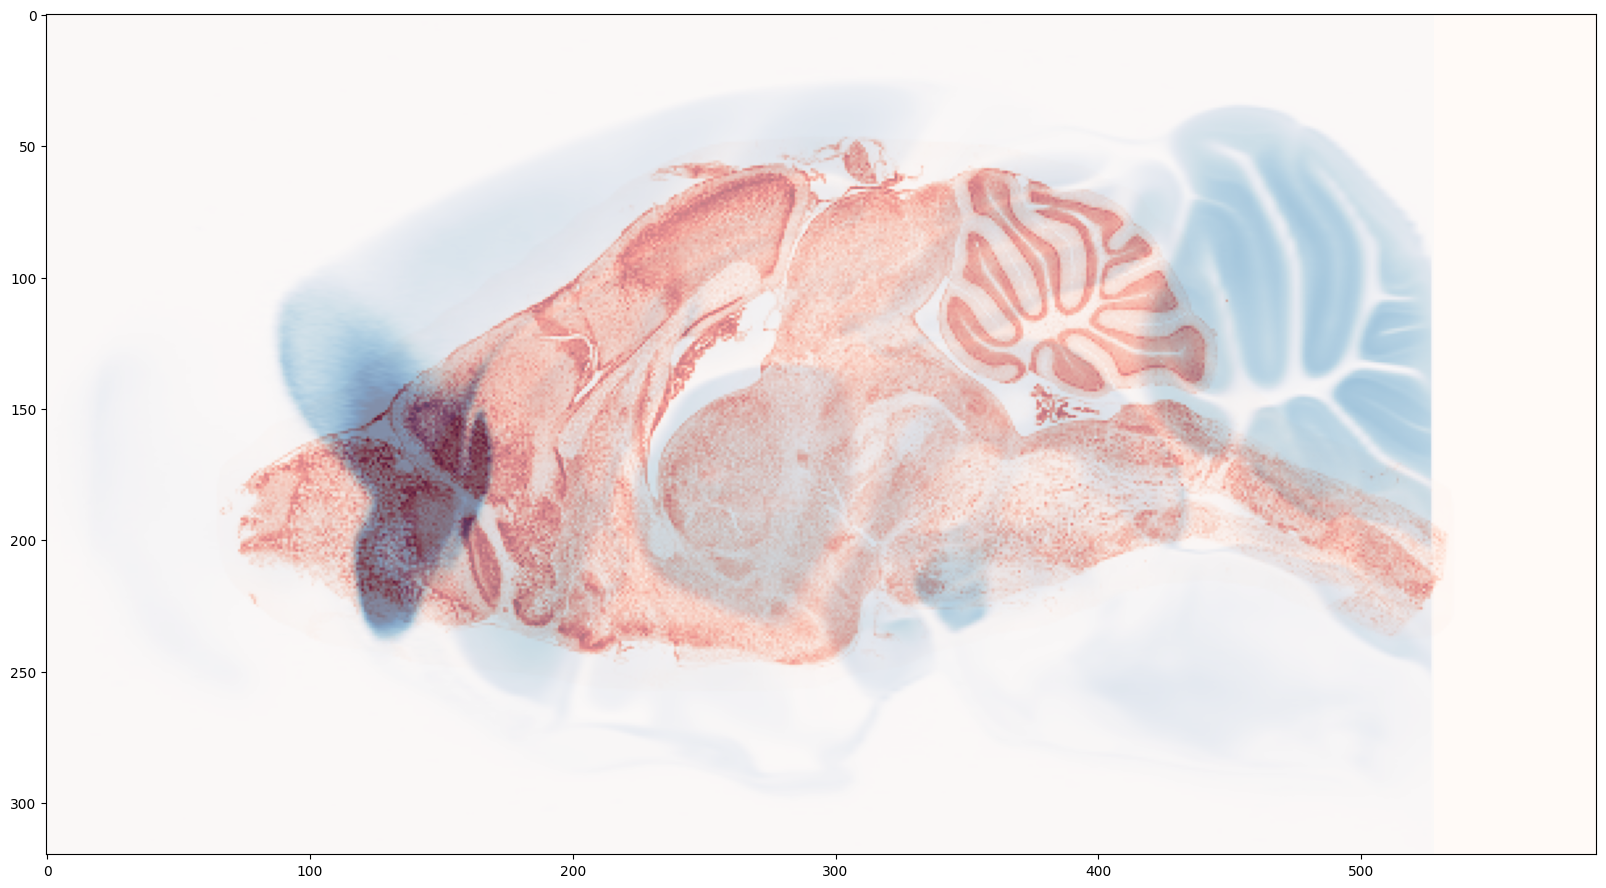

In [31]:
# blue is fixed, red is moving
compare_two_images(fixed_image, moving_image)

In [ ]:
# cornal to sagittal volume
arr = np.swapaxes(fixed_volume, 0,2)
#arr = np.rot90(arr, 1, axes=(0,1))
#arr = np.flip(arr, axis=0)
outpath = os.path.join(REGDATA, 'allen_50um_sagittal.tif')
imwrite(outpath, arr)

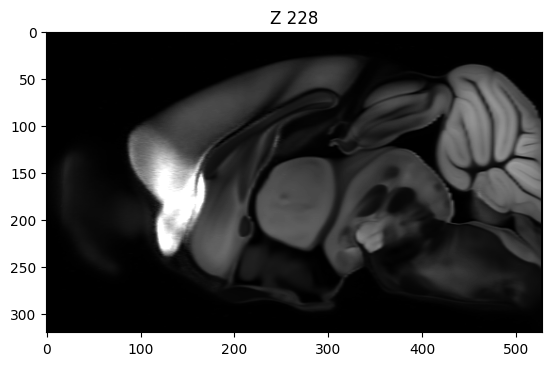

In [27]:
#arr = fixed_volume
plt.title('Z {}'.format(fixed_midpoint))
plt.imshow(fixed_image, cmap="gray")
plt.show()

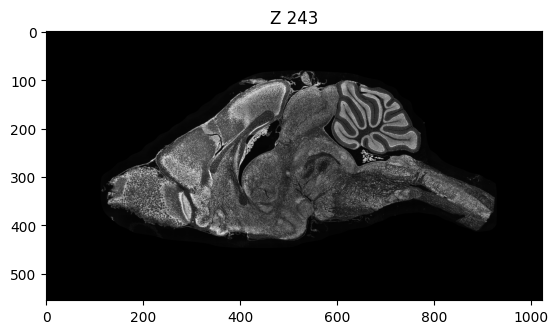

In [28]:
plt.title('Z {}'.format(moving_midpoint))
plt.imshow(moving_image, cmap="gray")
plt.show()

In [ ]:
#scaled = zoom(moving_volume, zoom=(1, scaler, scaler))
#print(scaled.shape)
outpath = os.path.join(DATA, 'scaled_volume.tif')
imwrite(outpath, moving_volume)
#vm2 = np.swapaxes(volume, 0,2)
#print(vm2.shape)
#outpath = os.path.join(DATA, 'allen_50um_sagittal.tif')
#imwrite(outpath, vm2)

In [ ]:
#arr = normalize16(volume)
arr = volume
arr = np.swapaxes(volume, 0,2)
midpoint = arr.shape[2] // 2
limit = 8
start = midpoint - 10
end = midpoint + 10
for i in tqdm(range(start, end, 4)):
    plt.title('Z {}'.format(i))
    img = arr[:,:,i]
    #img = np.rot90(img, 1, axes=(1,0))
    #img = np.flip(img, axis=1)
    #plt.imshow(img, cmap="seismic")
    #plt.show()

In [ ]:
image_stack = np.zeros(volume.shape)
file_list = []

for i in tqdm(range(0, volume.shape[2], 1)):
    img = volume[:,:,i]
    img = np.rot90(img, 1, axes=(1,0))
    img = np.flip(img, axis=1)
    filepath = os.path.join(OUTPUT, str(i).zfill(3) + '.tif')
    cv2.imwrite(filepath, img)

In [ ]:
# The default atlas created by brainreg is isotropic 25um
vm2 = volume
#print(f'Orig volume shape={sagittal.shape}')
#vm2 = np.swapaxes(volume, 0,2)
#sagittal = np.rot90(sagittal, axes=(1, 0))
#sagittal = np.flip(sagittal, axis=1)
print(f'new volume shape={vm2.shape}')

dimensions = neuroglancer.CoordinateSpace(
    names=['x', 'y', 'z'],
    units='um',
    scales=[20,20,20])
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.dimensions = dimensions
    s.layout = '4panel'
    s.layers['Princeton'] = neuroglancer.SegmentationLayer(
        source=neuroglancer.LocalVolume(
            data=vm2,
            dimensions=dimensions,
            voxel_offset=(0, 0, 0),
        ))

print(viewer)